In [ ]:
import pandas as pd
import numpy as np
import itertools

#Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
plt.style.use('seaborn-white')
%matplotlib inline

#statistics libraries
import statsmodels.api as sm
import scipy
from scipy.stats import anderson
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung

from statsmodels.tsa.statespace.tools import diff as diff
import pmdarima as pm
from pmdarima import ARIMA, auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import signal
from scipy.stats import shapiro
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
from scipy.stats import jarque_bera as jb
import datetime, dateutil
from fbprophet import Prophet
from sklearn.linear_model import LinearRegression, RidgeCV
from itertools import combinations
from statsmodels.tsa.seasonal import STL
from udacity_project import residcheck

from udacity_project import plot_pgram

plt.rc('font',size=13)




import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
np.random.seed(786)
pd.plotting.register_matplotlib_converters()

# Import & Clean Data

In [ ]:
# Data Import & Cleaning using custom function

from forecast import import_data, clean_data, fuel_data

df = (import_data('fuel_pbi.csv')) #Original data


clean_df = (
        import_data('fuel_pbi.csv') # import data
        .pipe(clean_data)           # remove unwanted columns, change dtypes, clean $
    
     )


pellet, briquette, firewood = (
     
    
        import_data('fuel_pbi.csv')
        .pipe(clean_data)
        .pipe(fuel_data)           #create three different dataframes for each fuel type
    )

In [ ]:
#Original Data
df.head()

,Avg_Temp,Avg_Demand,Fuel,Sales
Date,,,,
2013-09-01,13.899127,1.912222,Briquettes,"$5,809.395"
2013-09-01,13.899127,1.912222,Firewood,"$29,153.8228"
2013-09-01,13.899127,1.912222,Pellets,"$39,583.4117"
2013-10-01,12.471813,3.097542,Briquettes,"$17,555.1663"
2013-10-01,12.471813,3.097542,Firewood,"$56,683.4043"


In [ ]:
#Cleaned Data
clean_df.head(3)

,Avg_Temp,Avg_Demand,Fuel,Sales
Date,,,,
2013-09-01,13.899127,1.912222,Briquettes,5809.3950
2013-09-01,13.899127,1.912222,Firewood,29153.8228
2013-09-01,13.899127,1.912222,Pellets,39583.4117


In [ ]:
#Individual fuel sales
pellet.head(3)

Date
2013-09-01    39583.4117
2013-10-01    77603.4924
2013-11-01    93789.6064
Name: Pellet, dtype: float64

In [ ]:
print("Number of Months each fuel:",len(pellet), "months")

Number of Months each fuel: 78 months


# Data Description

This is real sales data from an Irishwood fuel reseller. After reading the blog of one of the team members (Sandeep), the sales manager from this fuel supplier contacted him and asked if would like to help him create forecast for rest of the year. This data is from Sept 2013 to Mar 2020, total 78 months. Data Description:

* - Date*       : Sales Month & Year
* - Avg_Temp *  : Average temperature in that city for that month & year.
* - Avg_Demand :* Internal metric used to track demand
* - Fuel       :* Fuel type. There are three wood-based fuels, Pellet, Briquette & Firewood. You can read about fuels [here](https://biofuelz.com/), as an example
* - Sales *     : Aggregate sales that month-year

# Project Goals

- Gather insights from data analysis that the fuel supplier can use
- Create accurate, robust forecast for CY2020
- The supplier is more interested in forecast accuracy than forecast uncertainty, so forecasting models will be evaluated for accuracy rather than uncertainty
- The supplier is a small company without a DS team and would like to use simpler models that he can use, debug, maintain easily.  
- Provide metrics to detect data drift 
- Build a fair and inclusive ML solution
- Use Azure ML Service to deploy the model locally & use Power BI to consume the model & track forecast

# Exploratory Data Analysis

We will keep the last 12 months of data for validation & test and use rest of the data for EDA and model training

### Aggregate Sales

In [ ]:
clean_df.isna().sum()

Avg_Temp      0
Avg_Demand    0
Fuel          0
Sales         0
dtype: int64

In [ ]:
# aggregate monthly sales 

agg_df = (clean_df[["Sales"]]
.sort_index()
.resample('M')
.sum()
.iloc[:-12]
         )

len(agg_df)

66

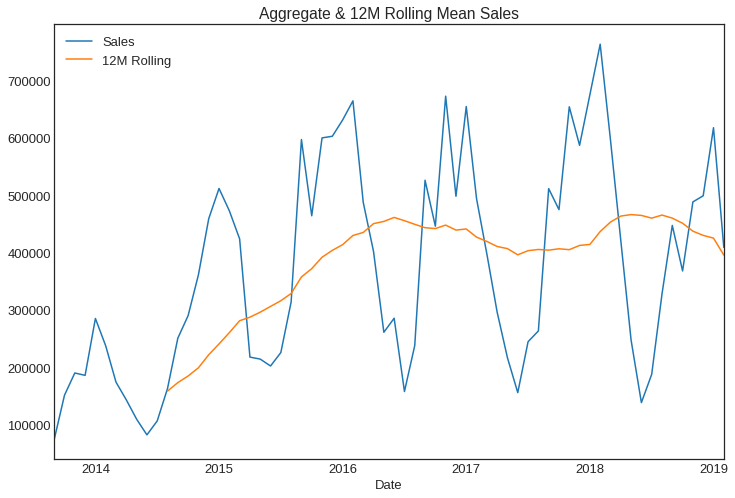

In [ ]:
agg_df.Sales.plot(figsize=(12,8), title="Aggregate & 12M Rolling Mean Sales", sharex=True, legend=True, label="Sales");
agg_df.Sales.rolling(12).mean().plot(legend=True, label="12M Rolling");


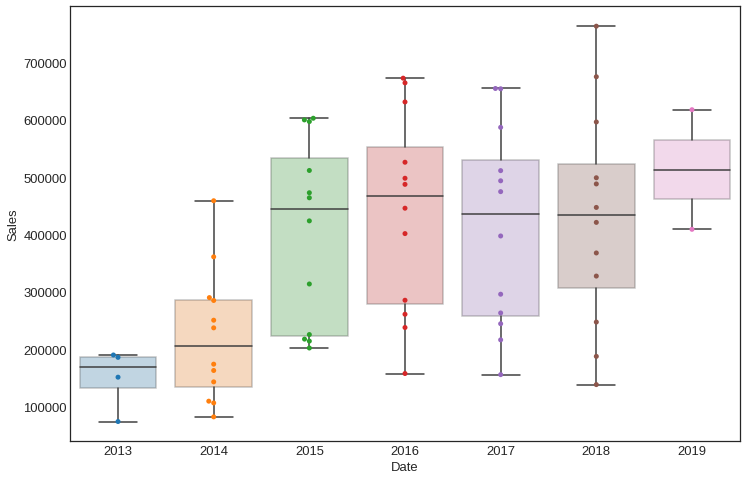

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))
sns.boxplot(data=agg_df, x=agg_df.index.year, y = 'Sales',  ax = ax, boxprops=dict(alpha=.3));
sns.swarmplot(data=agg_df, x=agg_df.index.year, y = 'Sales');

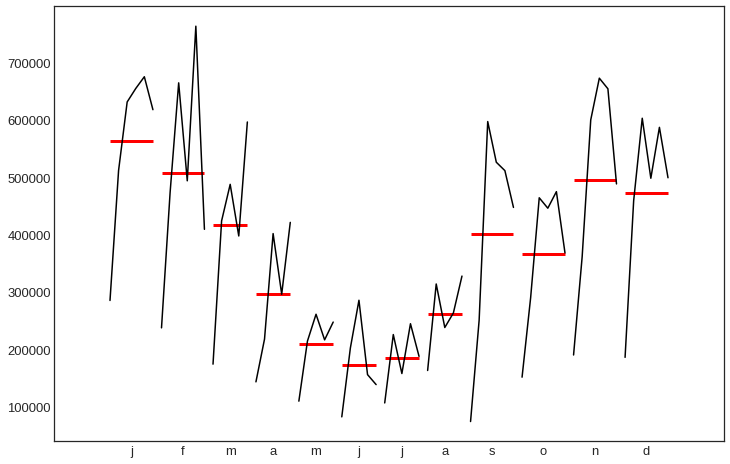

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8.0)
month_plot(agg_df);

## Observations: 

1. Sales plot shows clear seasonal pattern 
2. Sales went up from 2013 to 2016, went down in 2017, then again increased in 2018. 2019 Looks soft year with a downward train but $/mo is higher. 
3. Overall variability has remained the same, 2018 being the exception. 
4. Month plot show, sales go down during summer months (June, July, August), go up in winter months. 
5. Interestingly, sales drop in October. We asked the supplier about it and we were told that the reason is because fuel prices go up at the end of September so people buy fuel in September and not much in October
6. Time series is not stationary.
7. No null values and outliers

# Individual Fuel Sales

''

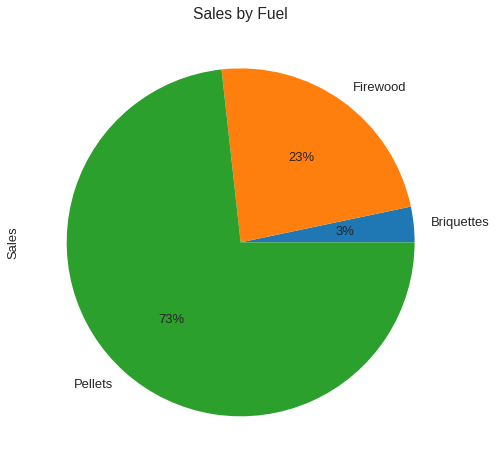

In [ ]:
(clean_df.iloc[:-12].groupby(['Fuel'])['Sales']
 .sum()
 .plot(kind='pie', 
       title= "Sales by Fuel", 
       autopct='%1.0f%%', 
        ))
;

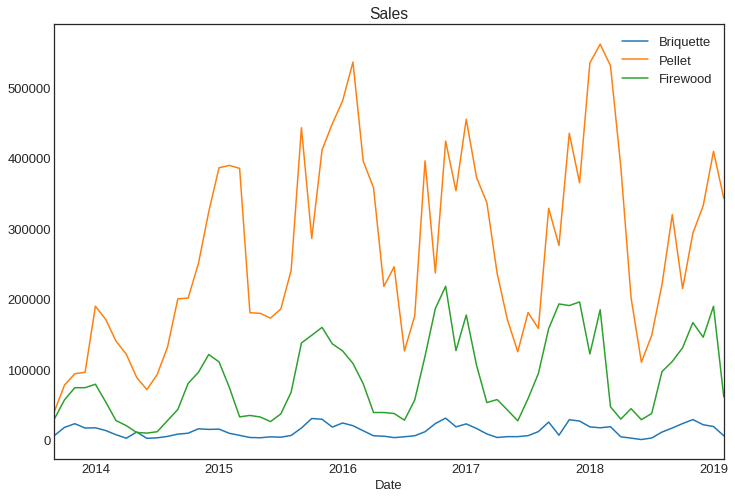

In [ ]:
# Sales for all years


briquette.iloc[:-12].plot(figsize=(12,8), legend=True, label='Briquette', title = "Sales")
pellet.iloc[:-12].plot(legend=True, label='Pellet')
firewood.iloc[:-12].plot(legend=True, label='Firewood');

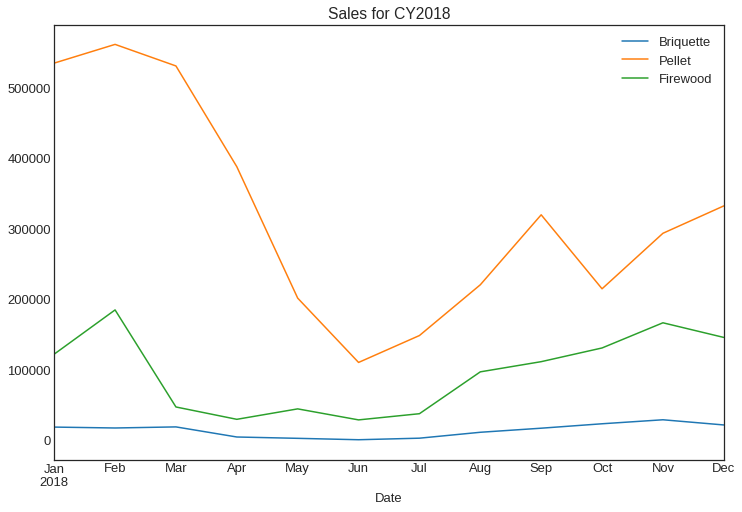

In [ ]:
#Sales for last full year 2018


briquette['2018'].plot(figsize=(12,8), legend=True, label='Briquette', title = "Sales for CY2018")
pellet['2018'].plot(legend=True, label='Pellet')
firewood['2018'].plot(legend=True, label='Firewood');

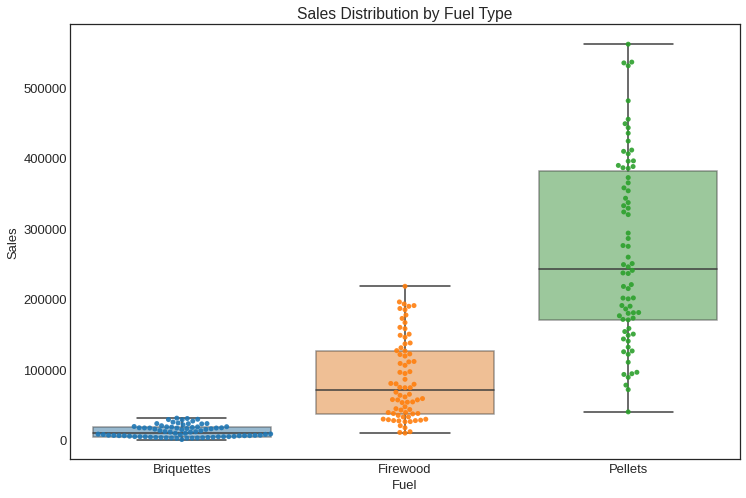

In [ ]:
#Sales Distribution by Fuel Type

fig, ax = plt.subplots(figsize = (12,8))
sns.boxplot(x='Fuel', y ='Sales', data=clean_df.iloc[:-12], ax= ax, boxprops=dict(alpha=.5))
sns.swarmplot(x='Fuel', y ='Sales', data=clean_df.iloc[:-12], alpha=0.9);
ax.set_title("Sales Distribution by Fuel Type");

## Observations: 

1. Pellet accounts for 73% of the sales, followed by firewood (24%) and briquette (only 3%)
2. Overall no outliers, data is clean 
3. Individuals fuel sales follow overall global trend 
4. Note from CY2018 plot that sales drop in October for Pellet but not for Firewood.
5. Fuel sales peak in different months 
6. % Firewood increased in 2019 compared to Pellet
7. All three fuels follow same seasonality pattern of 12 months
8. All are non-stationary


## Effect of Temperature & Avg Demand

In [ ]:
temp = clean_df.iloc[:-12][["Avg_Temp","Avg_Demand","Sales", "Fuel"]]

#Correlation between Temp & Demand
temp[["Avg_Temp","Avg_Demand"]].resample('M').mean().corr()

,Avg_Temp,Avg_Demand
Avg_Temp,1.000000,-0.993575
Avg_Demand,-0.993575,1.000000


In [ ]:
#Correlation between Temp & Sales
temp[["Avg_Temp","Sales"]].resample('M').sum().corr()

,Avg_Temp,Sales
Avg_Temp,1.000000,-0.603254
Sales,-0.603254,1.000000


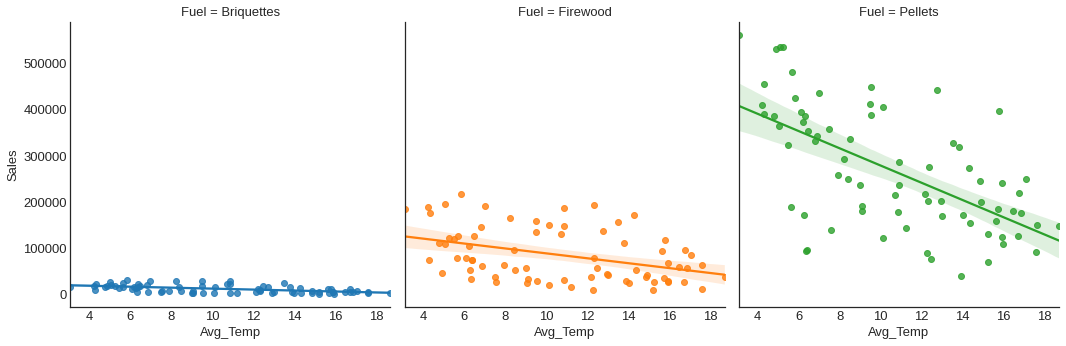

In [ ]:
#Avg Temp vs Sales Correlation

sns.lmplot(data = temp, x='Avg_Temp', y = 'Sales', col= 'Fuel', hue='Fuel', sharey=True);


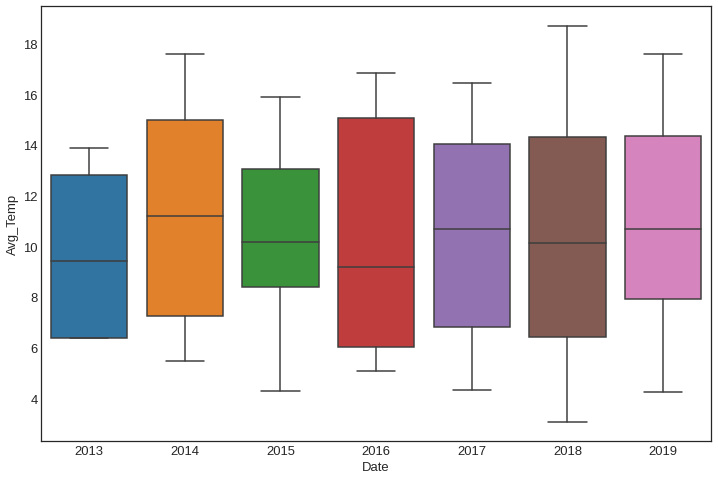

In [ ]:
#Distribution of Temp Every Year to spot outliers

fig, ax = plt.subplots(figsize = (12,8))
sns.boxplot(data=temp, x=temp.index.year, y = 'Avg_Temp', ax=ax);


Text(0.5, 0, 'Month')

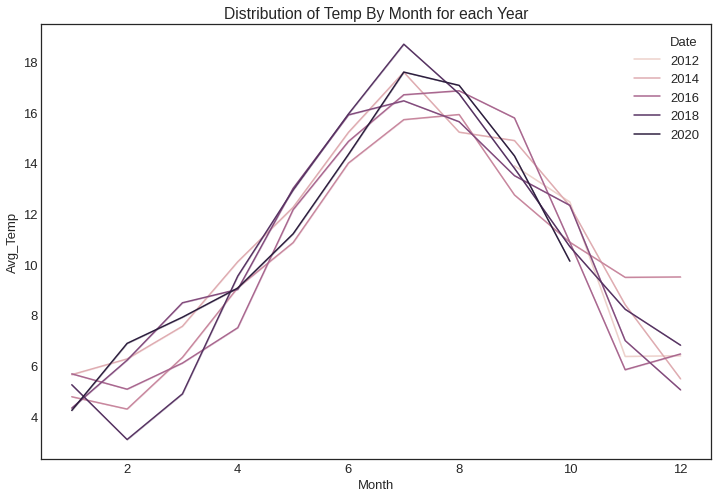

In [ ]:
#Distribution of Temp by Month for each Year to spot outliers

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(data=temp, y='Avg_Temp', x = temp.index.month, hue=temp.index.year);
ax.set_title("Distribution of Temp By Month for each Year");
ax.set_xlabel("Month")

### Observations:

1. Avg temp and demand are perfectly correlated with each. We can drop of one them from the model.
2. Avg Temp and Sales have a strong inverse correlation, as expected. As the temperature goes down demand for fuel increases
3. Temp vs Sale correlation is cosistent for three fuels, more so for Firewood & Pellet than Briquette
4. Temperature could be used as an additional regressor 
5. Change in temperature every year and each month is consistent, there dont seem to be any outliers

## Sales by Each Fuel Type

### Pellet 

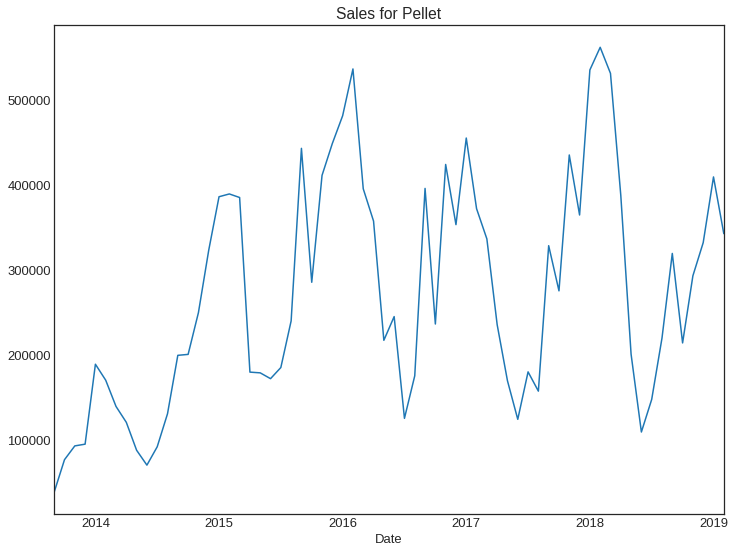

In [ ]:
pellet.iloc[:-12].plot(figsize=(12,9), title = "Sales for Pellet");

##### Autocorrelation Function & Partial Autocorrelation Function Plots

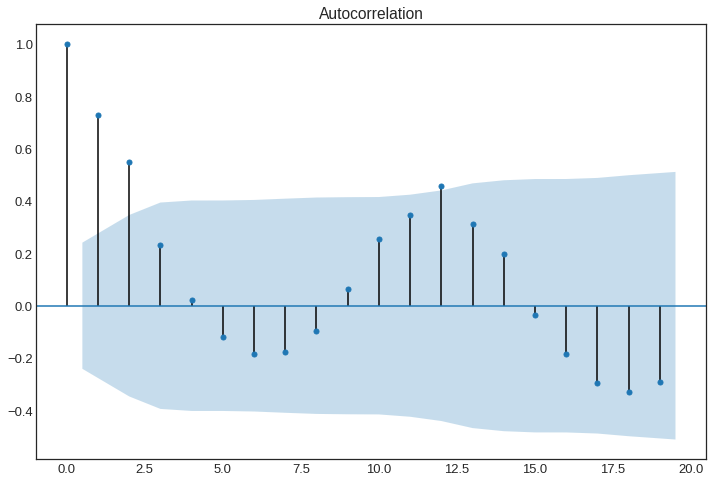

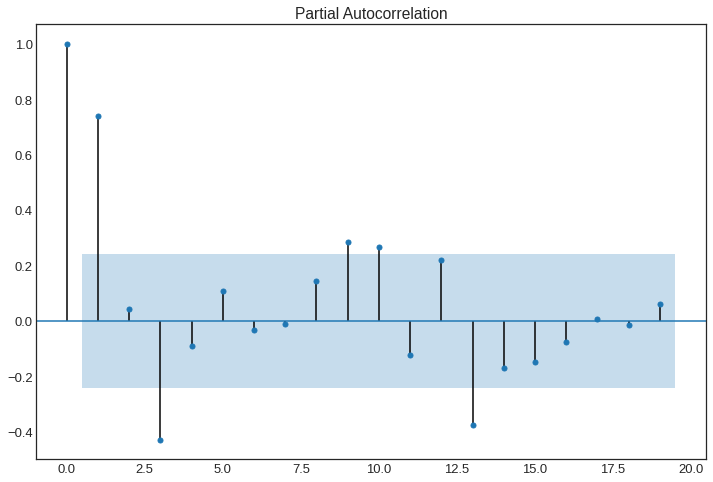

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8.0)
plot_acf(pellet.iloc[:-12]);
plot_pacf(pellet.iloc[:-12]);


#### Seasonal Decomposition of the time series

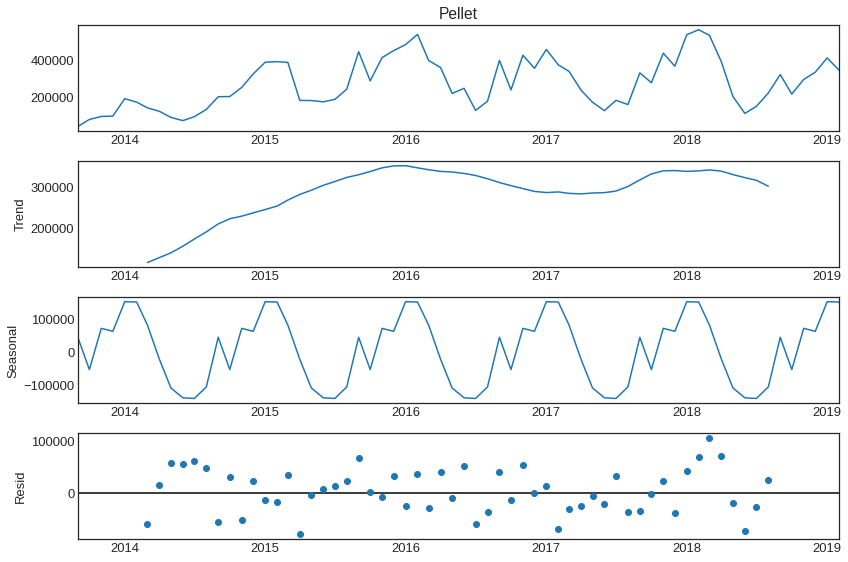

In [ ]:
decompose_p = seasonal_decompose(pellet.iloc[:-12])
plt.rcParams['figure.figsize'] = (12, 8.0)
decompose_p.plot();

#### Residual Diagnostics

In [ ]:
from udacity_project import residcheck


** Mean of the residuals:  4638.15

** Ljung Box Test, p-value: 0.315 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.594 (>0.05, Normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


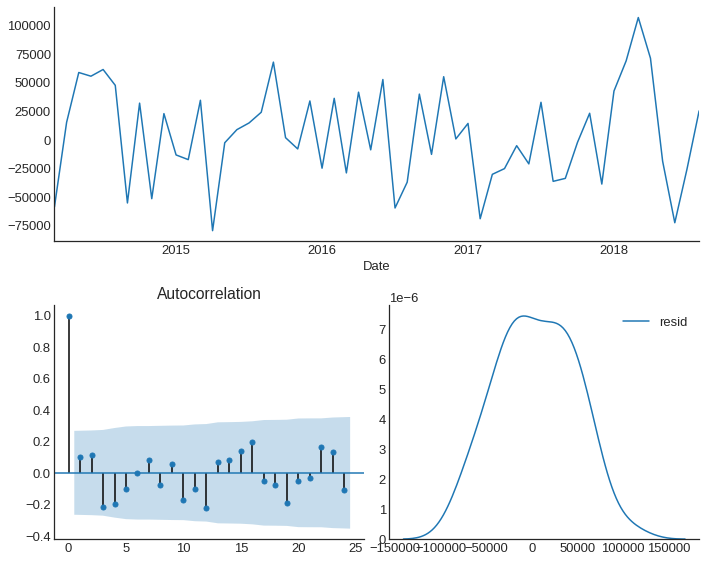

In [ ]:
residcheck(decompose_p.resid.dropna(),24);

#### periodogram for identifying dominant frequencies

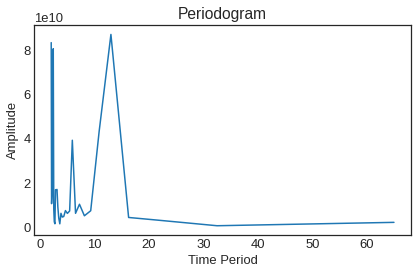

In [ ]:

plot_pgram(pellet.iloc[:-12],1);

#### Observations: 

1. ACF, PACF, Periodogram show seasonality =12. 
2. First two lags and 12th lag are significant. In fact, first 2 lags show very high autocorrelation. 
3. ACF shows gradual descrease -> presence of trend and alternating pattern -> seasonality
4. Time series is non-stationary. 
5. Decomposed time series shows residuals are uncorrelated and stationary
6. If ML model is used, first 12 lags should be used

### Firewood

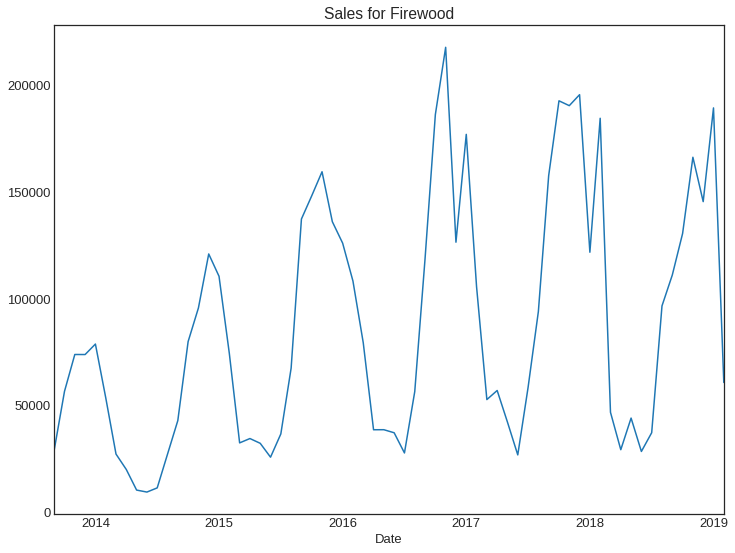

In [ ]:
firewood.iloc[:-12].plot(figsize=(12,9), title = "Sales for Firewood");

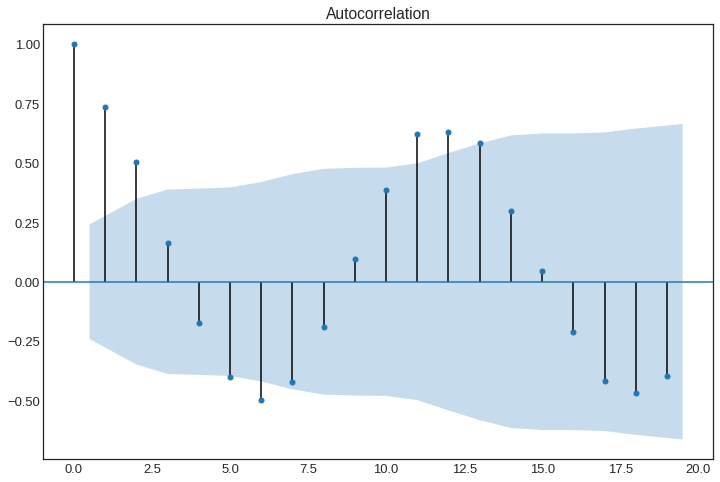

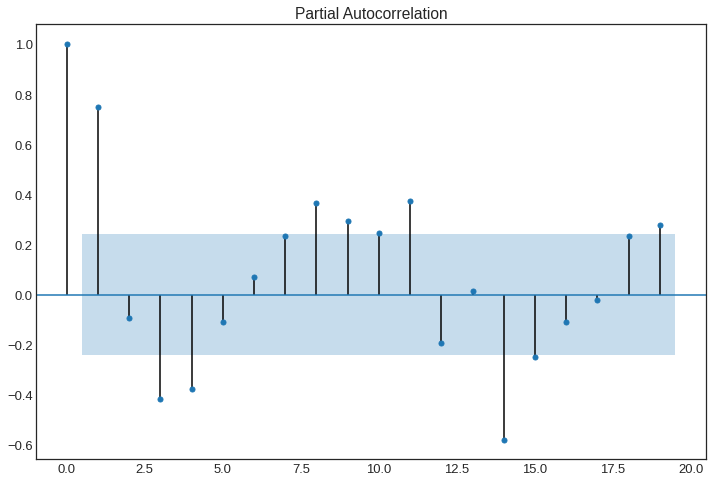

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8.0)
plot_acf(firewood.iloc[:-12]);
plot_pacf(firewood.iloc[:-12]);

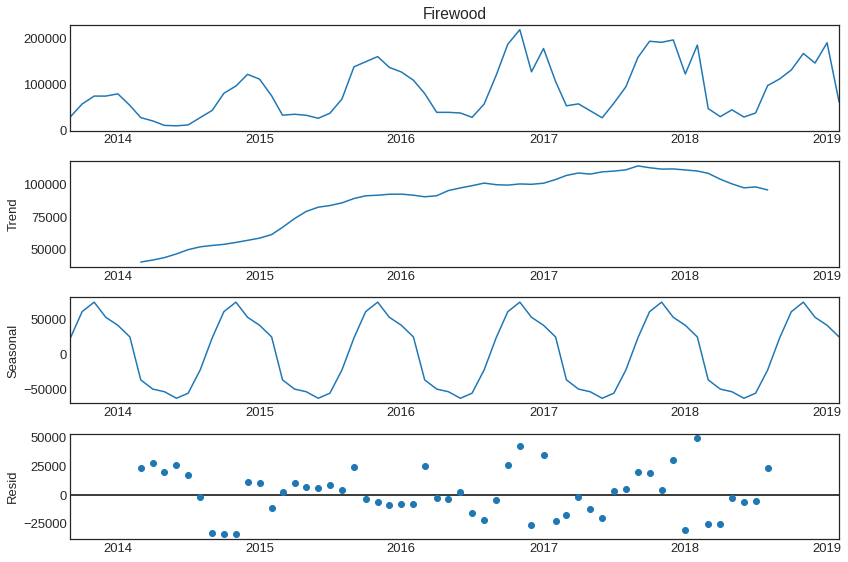

In [ ]:
decompose_f = seasonal_decompose(firewood.iloc[:-12])
plt.rcParams['figure.figsize'] = (12, 8.0)
decompose_f.plot();

** Mean of the residuals:  1548.41

** Ljung Box Test, p-value: 0.303 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.623 (>0.05, Normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


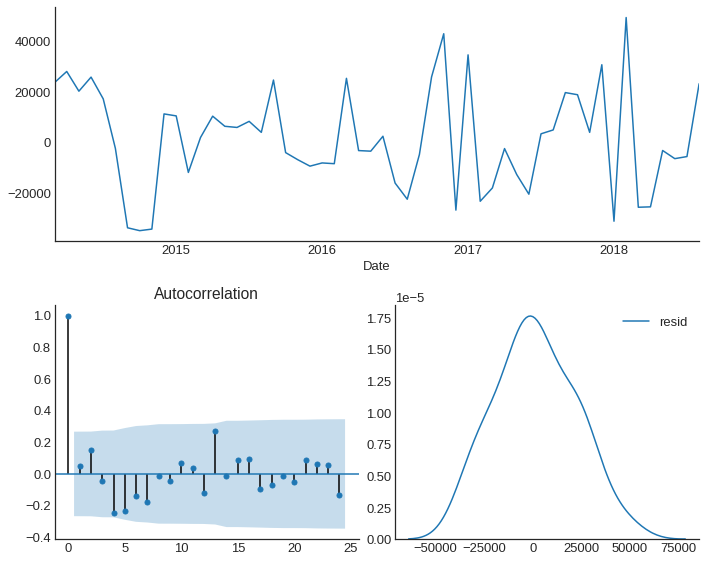

In [ ]:
#Residual Diagnostics
residcheck(decompose_f.resid.dropna(),24);

#### Observations: 

1. ACF, PACF show seasonality =12. (peaks at multiples of 6)
2. Lags that are significant - > 1,2,6,11,12
3. ACF shows gradual descrease -> presence of trend and alternating pattern -> seasonality
4. Time series is non-stationary. 
5. If ML model is used, first 12 lags hsould be used. 
6. Residuals are uncorrelated, stationary. 
7. Overall, for firewood, the sales in last two months, last 6 months and last season are indicative of next sales

### Briquette

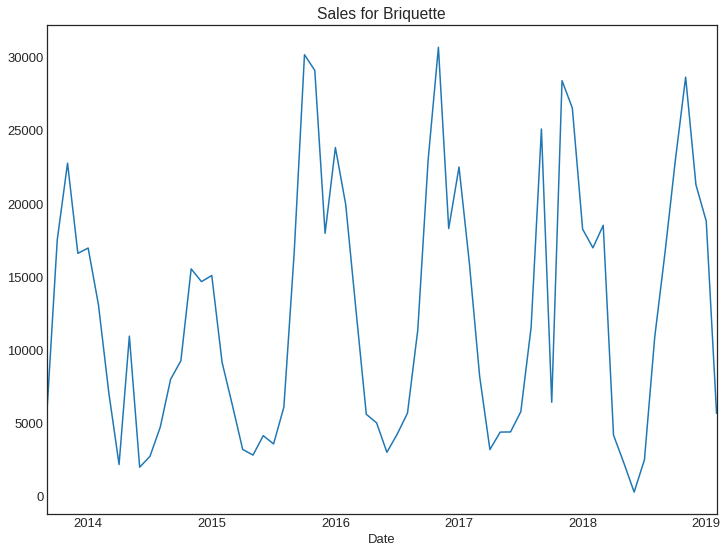

In [ ]:
briquette.iloc[:-12].plot(figsize=(12,9), title = "Sales for Briquette");

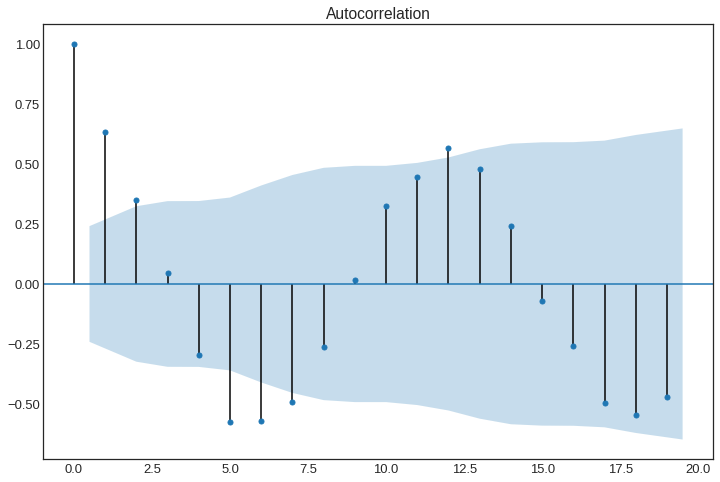

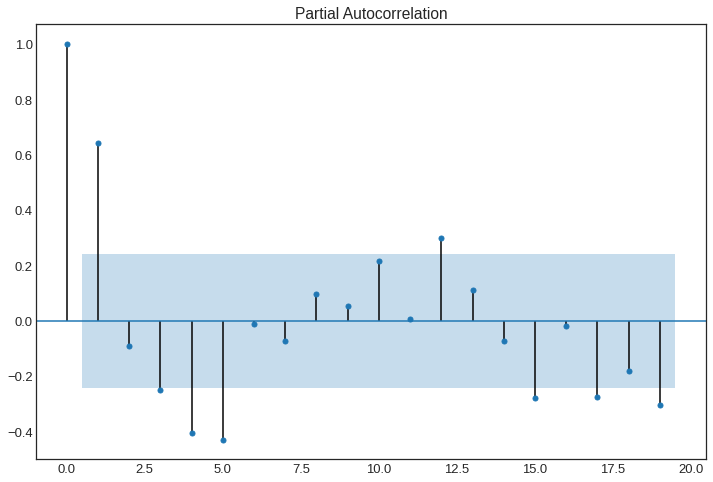

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8.0)
plot_acf(briquette.iloc[:-12]);
plot_pacf(briquette.iloc[:-12]);

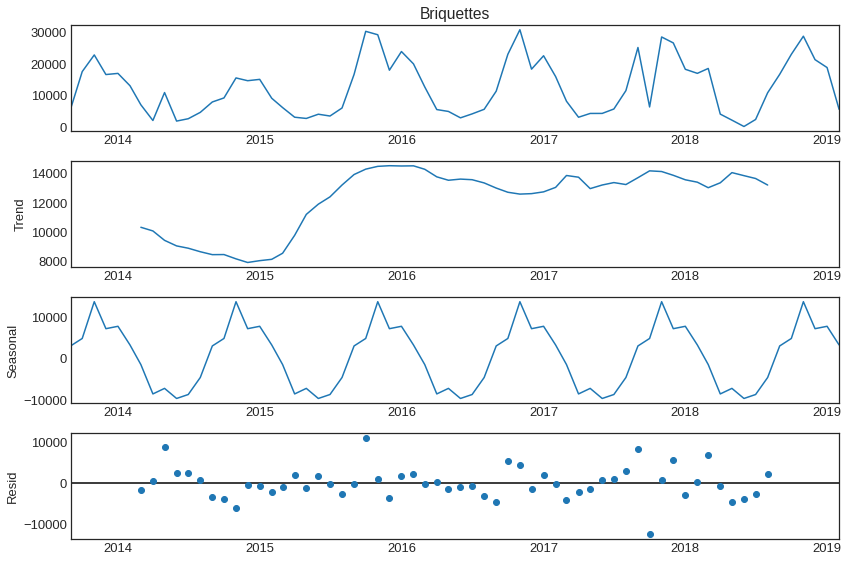

In [ ]:
decompose_b = seasonal_decompose(briquette.iloc[:-12])
plt.rcParams['figure.figsize'] = (12, 8.0)
decompose_b.plot();

** Mean of the residuals:  -7.15

** Ljung Box Test, p-value: 0.369 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.02 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


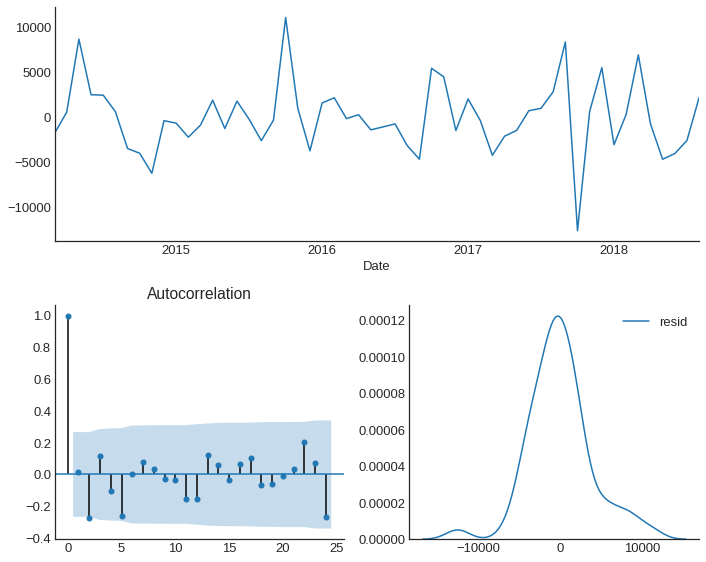

In [ ]:
residcheck(decompose_b.resid.dropna(),24);

#### Observations: 

1. ACF, PACFshow seasonality =12. (peaks around multiples of 6)
2. Lags that are significant - > 1,2,5,6,7,12
3. Weak trend
4. Time series is non-stationary. 
5. Residuals are uncorrelated and stationary
6. If ML model is used, first 12 lags should be used. 


# Model Training

For model building we exclusively focused on using classical forecasting methods because:
   - We have only 60 observations for each fuel type. ML models typically need large number of observations to capture non-linear behaviour in the time series
   - ML models work well when many features are present. In our case, only temperature data is available. The problem with using temperature data for forecasting is that to predict the future sales, we will also need to first predict the future temperatures, which is not an easy task and can lead to inaccurate results
   - The fuel supplier wants to maintain & update the forecast model without a dedicated data science team. So our focus is to create a modeling methodology that the supplier can easily follow, on his own, and train/update model in the future
   - Unlike other prediction problems where a model is trained once and data drift is monitored, in time series forecasting the model has to be trained again when new data are available. Our goal is to not only provide forecast algorithmn but to provide a framework for future models.  
   

### Individual Forecasting Models Used

- SES : Single Exponential Smoothing
- Holt : Holt's
- Damp : Damped Trend Method
- HW1 : Holt Winter
- Naive : Seasonal Naive
- ETS1 : Error Trend Seasonality
- ETS_BoxCox : Error Trend Seasonality with BoxCox Transformation
- SARIMA : Seasonal Auto Regressive, Integrated, Moving Average
- SARIMAX : Seasonal Auto Regressive, Integrated, Moving Average - Exogenous
- Prophet : Facebook Prophet
- CombSHD : Combination SHD
- BaggedETS : Bagged ETS model
- Median : Median of all the above models

## Novel Modeling Approaches

Along with the classical forecasting methods (Exponential smoothing, SARIMA, SARIMAX, Facebook Prophet, Naive), we created python implementation of two novel forecasting techniques - combshd & baggedETS. 

### CombSHD

CombSHD stands for *Combination- Single ExponentailSmoothing*, Holt's Method and Damped Method. While the method is not new, it's not available in Python to our knowledge. This method, although simple, has been shown to work better than even complex machin learning algorithms. As can be seen from the plot below from the M3 competition results, CombSHD, despite being simple, did as well as the complex methods and better than most other forecasting methods. 

In this method, three different forecasts are created and are combined to create the final forecast.

Below plot shows (statistical) rank vs method. The lower the rank, the more accurate the method

![](https://ars.els-cdn.com/content/image/1-s2.0-S0169207004000810-gr1.jpg)

### BaggedETS

BaggedETS is 'Bagging Exponential SMoothing' method. This is an ensemble forecasting method proposed by Prof. Rob Hyndman. The theory of this method can be read  [here](https://robjhyndman.com/papers/BaggedETSForIJF_rev1.pdf). In a nutshell, to create a forecast: 

 - Time Series is decomposed using STL decomposition
 - Residuals from the decomposition are bootstrapped
 - Recombined many times to obtain new series
 - Estimate a model for each bootstrapped series
 
 
 Prof. Hyndman shows in his paper that this method also has shown to be effective than many other forecasting methods and actually creates much more robust forecast.
 
 To our knowledge, there is no Python implementation of this method and we developed it for our project.

### Ensemble Forecasts

Individual forecasts from 10 different forecasting methods are created and are combined, resulting in 1100+ different forecast models. Best among them is chosen based on :
 - Error Metric : RMSE (since the data are free of outliers). The smaller the RMSE the better 
 - Parsimonious (i.e simple model with fewer parameters) 
 - Robust methods with previsouly known combinations are picked to avoud spurious fitting
 
 
 
 

## Modeling Procedure:

1. Create a train/validation/test split. First 75 months are used for training and validation. The last 3 months are held out.  
2. Expanding window cross-validation on Holt Winter's method is run to find parameters with smallest RMSE
2. Order of SARIMA is obtained using pmdarima  
3. 10 Different forecasts are obtained using various individual methods discussed below
4. All possible forecast combinations (1100+ models) are obtained by combining individual forecasts and averaging using median.
5. Final forecast combination is chosen for each fuel type by calcultaing RMSE for validation set (9 months)
6. Final model is created by training on all of the available dataset to create dynamic forecast


### Pellets

In [ ]:
# Create Train, Validation, Test set. Also create transformed versions using BoxCox.


p = clean_df[clean_df.Fuel=='Pellets'][['Sales','Avg_Temp']].sort_index()

len_test = 3
len_val = 9
len_train = len(p) - len_test - len_val

p_train = p.iloc[:len_train]
p_val = p.iloc[len_train:(len_train+len_val)]
p_test = p.iloc[-len_test:]
p_train_b, lam_p = boxcox(p_train.Sales)


p_train.index.freq='MS'
p_val.index.freq='MS'
p_test.index.freq='MS'

In [ ]:
from udacity_project import hw_cv


##### Find parameters for Holt Winter's method using expanding cross-validation

In [ ]:
import itertools


In [ ]:
hw_cv(p_train.Sales,12,36,6)

add add False False     ,Expanding RMSE : 99580.7
add add False True     ,Expanding RMSE : 96561.3
add add False log     ,Expanding RMSE : 102044.7
add add True False     ,Expanding RMSE : 84575.4
add add True True     ,Expanding RMSE : 86433.1
add add True log     ,Expanding RMSE : 85357.8
add mul False False     ,Expanding RMSE : 90092.7
add mul False True     ,Expanding RMSE : 93108.6
add mul False log     ,Expanding RMSE : 98260.8
add mul True False     ,Expanding RMSE : 87186.6
add mul True True     ,Expanding RMSE : 77150.6
add mul True log     ,Expanding RMSE : 85019.4
mul add False False     ,Expanding RMSE : nan
mul add False True     ,Expanding RMSE : 103475.4
mul add False log     ,Expanding RMSE : 93000.4
mul add True False     ,Expanding RMSE : nan
mul add True True     ,Expanding RMSE : 112268.1
mul add True log     ,Expanding RMSE : 96070.8
mul mul False False     ,Expanding RMSE : nan
mul mul False True     ,Expanding RMSE : 105265.2
mul mul False log     ,Expanding RMS

The results above shows Expanding CV error. Rolling CV is used when the data size is large. In our case, expanding is more appropriate so we are using average RMSE from expanding cv models to find the best HW model. In this case it's:

* add  mul True True    E: 77150.6*

Trend = 'add'

Seasonality ='mul'

Damped = True

Boxcox = True

##### Find Order for SARIMAX model

In [ ]:

(auto_arima(p_train.Sales,
           seasonal=True,
           m=12,                         
           d=1,                          
           information_criterion='aicc'). 
           summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   66
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -666.578
Date:                            Fri, 18 Sep 2020   AIC                           1341.156
Time:                                    05:28:50   BIC                           1349.037
Sample:                                         0   HQIC                          1344.187
                                             - 66                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4635      0.174     -2.660      0.008      -0.805      -0.122
ar.S.L12      -0.4194      0.195     -2.147      0.032      -0.802      -0.037
ar.S.L24      -0.2800      0.249     -1.124      0.261      -0.768       0.208
sigma2       5.71e+09   3.81e-12    1.5e+21      0.000    5.71e+09    5.71e+09
===================================================================================
Ljung-Box (Q):                       31.02   Jarque-Bera (JB):                 0.13
Prob(Q):                              0.84   Prob(JB):                         0.94
Heteroskedasticity (H):               0.95   Skew:                            -0.11
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.86e+37. Standard errors may be unstable.
"""

##### SARIMA Order

Order of SARIMA : SARIMAX(2, 1, 0)x(1, 0, 0, 12)

#### Obtain Individual Forecasts

In [ ]:
pellet_results = (ts(pd.concat([p_train,p_val]).Sales, 
    fc_horizon=len(p_val), 
    seasonality=12, 
    hw_trend='add', 
    hw_seasonal='mul',
    hw_damped=True,
    hw_bcox=True,
    sarima_O1=(2,1,0), 
    sarima_O2=(1,0,0,12),
    exog_series=p_train.Avg_Temp))

In [ ]:
pellet_results 

,Test,SES,Holt,Damp,HW1,Naive,ETS1,ETS_BoxCox,SARIMA,SARIMAX,Prophet,CombSHD,BaggedETS,Median
0,259395.8002,349910.228449,307741.150732,298077.179438,379385.940968,531234.6865,313733.169614,325151.469362,331472.337391,207477.359848,406876.629093,318576.186206,339665.625661,331472.337391
1,190697.3087,356850.706789,209919.148035,186594.603141,261078.500480,388117.7456,206579.053918,225645.550994,243225.547447,150753.328372,299959.957986,251121.485988,237299.702700,237299.702700
2,143169.0400,363855.994751,133591.242763,95082.425554,138226.781878,201458.5845,115487.734830,147815.100940,153033.553390,129166.102763,209200.201182,197509.887689,162406.674000,147815.100940
3,153713.8116,370926.031036,121609.558675,72750.929744,84232.253738,110104.5588,83224.038369,118206.414533,113035.216937,142151.523098,177377.463877,188428.839818,130721.317569,118206.414533
4,150092.5940,378060.755023,155766.344127,108774.293145,120002.936223,148324.3552,79578.339827,121152.804011,127738.250823,233930.107677,178752.189169,214200.464098,136894.182187,136894.182187
5,248829.3849,385260.106750,196411.178163,143542.483185,167530.773400,220418.4866,112905.284821,154749.940475,160672.347139,307431.541796,219250.145435,241737.922699,171147.004954,171147.004954
6,274736.0519,392524.026904,331976.779206,268400.227724,252040.709298,319811.5479,254372.390653,285214.270870,273569.086869,366397.353633,351237.076071,330967.011278,279582.285063,285214.270870
7,406191.9311,399852.456808,242967.445660,197206.162965,182203.498088,214712.8501,175796.267888,219953.442029,201977.116920,322314.082927,270183.542013,280008.688478,235267.311132,219953.442029
8,349312.4180,407245.338405,361645.261860,309989.251353,270815.089765,293559.8294,272717.340979,310106.119050,293226.623711,297778.184150,377603.882043,359626.617206,323929.067197,309989.251353


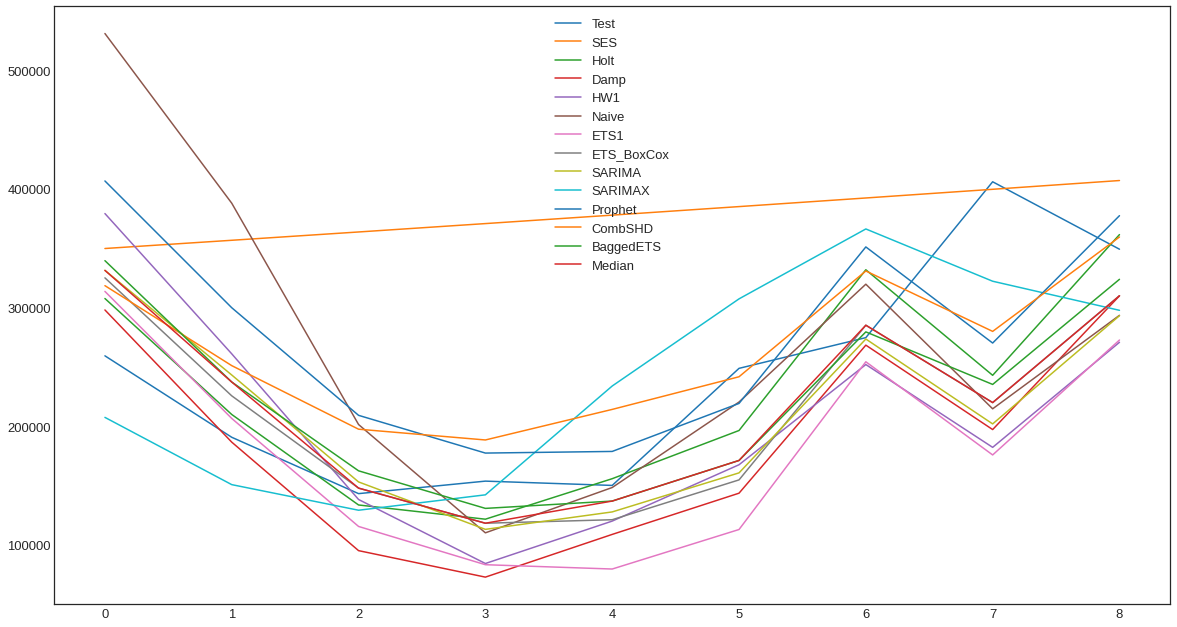

In [ ]:
pellet_results.plot(figsize=(20,11));

In [ ]:
# Calculate RMSE for individual Models 
for column in pellet_results.columns[1:]:
    print(column,":", rmse(pellet_results.Test, pellet_results[column]).round(1) )
    

SES : 156182.6
Holt : 63840.0
Damp : 87199.9
HW1 : 99200.0
Naive : 133660.2
ETS1 : 100968.2
ETS_BoxCox : 76628.8
SARIMA : 83551.9
SARIMAX : 60715.0
Prophet : 85281.5
CombSHD : 62059.2
BaggedETS : 71184.8
Median : 75423.8


In [ ]:
#Combine individual models, find the median of the RMSE 

combinations(pellet_results).sort_values('RMSE').head(10)

,Models,RMSE
0,['Holt'],63840.0
95,"['Holt', 'Damp', 'Prophet']",63840.0
54,"['SES', 'Holt', 'Damp']",63840.0
57,"['SES', 'Holt', 'ETS1']",64373.2
110,"['Holt', 'ETS1', 'Prophet']",64373.2
397,"['SES', 'Holt', 'Damp', 'ETS1', 'Prophet']",64373.2
179,"['SES', 'Holt', 'Damp', 'Prophet']",65834.0
180,"['SES', 'Holt', 'Damp', 'BaggedETS']",65968.7
25,"['Holt', 'BaggedETS']",65968.7
278,"['Holt', 'Damp', 'Prophet', 'BaggedETS']",65968.7


In [ ]:
print("Total Forecast model combinations calculated: ", len (combinations(pellet_results)))

Total Forecast model combinations calculated:  1022


#### Observation

 -  SARIMAX has the lowest RMSE on the validation set $60715 followed by Combshd and Holt. But we will have to create a forecast for temperature too if we use SARIMAX which will add to the error
That's why sarimax is usually not preferred if the regressor cant be controlled
 - It's also worth noting that the top combination models include 'Holt', 'Damp', 'SES' which are elements of comshd, so overall combshd should provide robust forecast 

##### Final Pellet Model 

In [ ]:
#### Final Pellet Model 

def pellet_forecast(train,forecast_horizon):
    
    train_x,lam = boxcox (train)
    ses=sm.tsa.statespace.ExponentialSmoothing(train_x,
                                           trend=True, 
                                           seasonal=None,
                                           initialization_method= 'estimated', 
                                           damped_trend=False).fit()
    
    fc1 = inv_boxcox(ses.forecast(forecast_horizon),lam)
    
    holt=sm.tsa.statespace.ExponentialSmoothing(train_x,
                                           trend=True, 
                                           seasonal=12,
                                           initialization_method= 'estimated', 
                                           damped_trend=False).fit()
    
    fc2 = inv_boxcox(holt.forecast(forecast_horizon),lam)
    
    damp=sm.tsa.statespace.ExponentialSmoothing(train_x,
                                           trend=True, 
                                           seasonal=12,
                                           initialization_method= 'estimated', 
                                           damped_trend=True).fit()
    
    fc3 = inv_boxcox(damp.forecast(forecast_horizon),lam)
    
    fc = (fc1+fc2+fc3)/3
    return fc

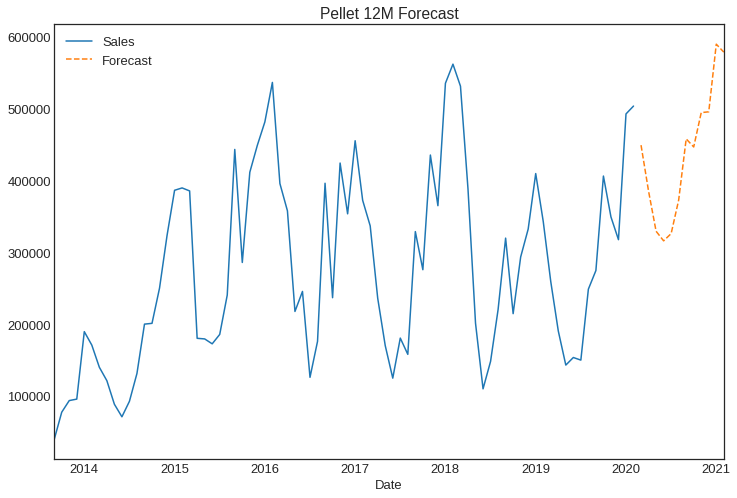

In [ ]:
fc_dates = pd.date_range(start= '2020-03-01', periods = 12, freq='MS')
pellet.plot(figsize= (12,8), title = "Pellet 12M Forecast", legend= True, label = "Sales")
pd.Series(data= pellet_forecast(pellet, 12), index = fc_dates).plot(legend= True, label = "Forecast", style = "--");

## Firewood

In [ ]:
f = clean_df[clean_df.Fuel=='Firewood'][['Sales','Avg_Temp']].sort_index()

len_test = 3
len_val = 9
len_train = len(p) - len_test - len_val

f_train = f.iloc[:len_train]
f_val = f.iloc[len_train:(len_train+len_val)]
f_test = f.iloc[-len_test:]
f_train_b, lam_f = boxcox(f_train.Sales)


f_train.index.freq='MS'
f_val.index.freq='MS'
f_test.index.freq='MS'

#### Obtain HW params

In [ ]:
hw_cv(f_train.Sales,12,36,6)

add add False False     ,Expanding RMSE : 44329.6
add add False True     ,Expanding RMSE : 32724.0
add add False log     ,Expanding RMSE : 42849.0
add add True False     ,Expanding RMSE : 42026.0
add add True True     ,Expanding RMSE : 30532.3
add add True log     ,Expanding RMSE : 37070.5
add mul False False     ,Expanding RMSE : 33855.6
add mul False True     ,Expanding RMSE : 39629.4
add mul False log     ,Expanding RMSE : 48612.2
add mul True False     ,Expanding RMSE : 30029.7
add mul True True     ,Expanding RMSE : 36102.8
add mul True log     ,Expanding RMSE : 39250.6
mul add False False     ,Expanding RMSE : nan
mul add False True     ,Expanding RMSE : 33243.7
mul add False log     ,Expanding RMSE : 44335.6
mul add True False     ,Expanding RMSE : nan
mul add True True     ,Expanding RMSE : 534758.1
mul add True log     ,Expanding RMSE : 119796.9
mul mul False False     ,Expanding RMSE : nan
mul mul False True     ,Expanding RMSE : 39671.9
mul mul False log     ,Expanding RMSE 

#### Find SARIMA Order

In [ ]:
#SARIMA

(auto_arima(f_train.Sales,
           seasonal=True,
           m=12,                         
           d=1,                          
           information_criterion='aicc'). 
           summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   66
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                -626.842
Date:                             Fri, 18 Sep 2020   AIC                           1261.685
Time:                                     06:09:27   BIC                           1269.566
Sample:                                          0   HQIC                          1264.715
                                              - 66                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1870      0.201      0.931      0.352      -0.207       0.581
ma.L1         -0.8412      0.165     -5.088      0.000      -1.165      -0.517
ar.S.L12      -0.6923      0.166     -4.179      0.000      -1.017      -0.368
sigma2       1.47e+09   3.91e-11   3.76e+19      0.000    1.47e+09    1.47e+09
===================================================================================
Ljung-Box (Q):                       39.54   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.49   Prob(JB):                         0.83
Heteroskedasticity (H):               2.62   Skew:                             0.09
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.53e+35. Standard errors may be unstable.
"""

#### Individual Forecasts for Firewood

In [ ]:
firewood_results = (ts(pd.concat([f_train,f_val]).Sales, 
    fc_horizon=len(f_val), 
    seasonality=12, 
    hw_trend='add', 
    hw_seasonal='mul',
    hw_damped=True,
    hw_bcox=False,
    sarima_O1=(1,1,0), 
    sarima_O2=(2,0,0,12),
    exog_series=f_train.Avg_Temp))

In [ ]:
firewood_results

,Test,SES,Holt,Damp,HW1,Naive,ETS1,ETS_BoxCox,SARIMA,SARIMAX,Prophet,CombSHD,BaggedETS,Median
0,64624.4792,61462.832585,49441.296361,48794.397916,48426.590580,46846.7002,61728.961794,51755.131898,45018.466050,14354.309232,81939.230416,53232.842287,47441.921669,48794.397916
1,25631.8807,62089.935863,37784.419829,30629.094674,34436.893943,29316.0117,46079.542195,38997.858810,34613.703149,8692.130574,69387.150056,43501.150122,35871.632106,35871.632106
2,17052.0489,62721.595226,34248.061769,45795.168375,35374.051225,44144.6978,40003.043950,34764.157014,31672.778118,18412.105343,67626.866417,47588.275123,31147.411015,35374.051225
3,53397.1726,63357.830469,26600.363763,29633.551359,23296.234775,28497.2744,28424.300626,26600.864764,24729.301904,22569.488923,59760.954201,39863.915197,23625.268753,26600.864764
4,63136.1675,63998.661413,34555.986072,38578.949286,35554.598451,37285.5087,33675.027738,34040.092041,32029.505512,56527.167810,67618.237470,45711.198924,29980.259285,35554.598451
5,85870.0604,64644.107910,69336.567160,99140.585490,71205.679800,96744.8209,64371.080029,67652.640077,63359.419903,107680.039758,102058.538812,77707.086853,61753.598348,69336.567160
6,172345.0853,65294.189841,110227.346547,113692.231034,113108.566070,111201.5406,103753.027573,108462.683600,100734.287405,137891.454282,139516.253191,96404.589141,96390.295054,110227.346547
7,149981.8719,65948.927114,151272.508790,133301.671247,145295.236740,130666.3994,133029.930646,146638.433192,137145.955832,171121.978033,171224.728154,116841.035717,136805.709450,137145.955832
8,196675.7672,66608.339664,173424.475929,169383.030556,163513.613760,166427.8825,147685.012102,165768.749446,156945.797667,122405.054011,197430.899236,136471.948716,155630.912737,163513.613760


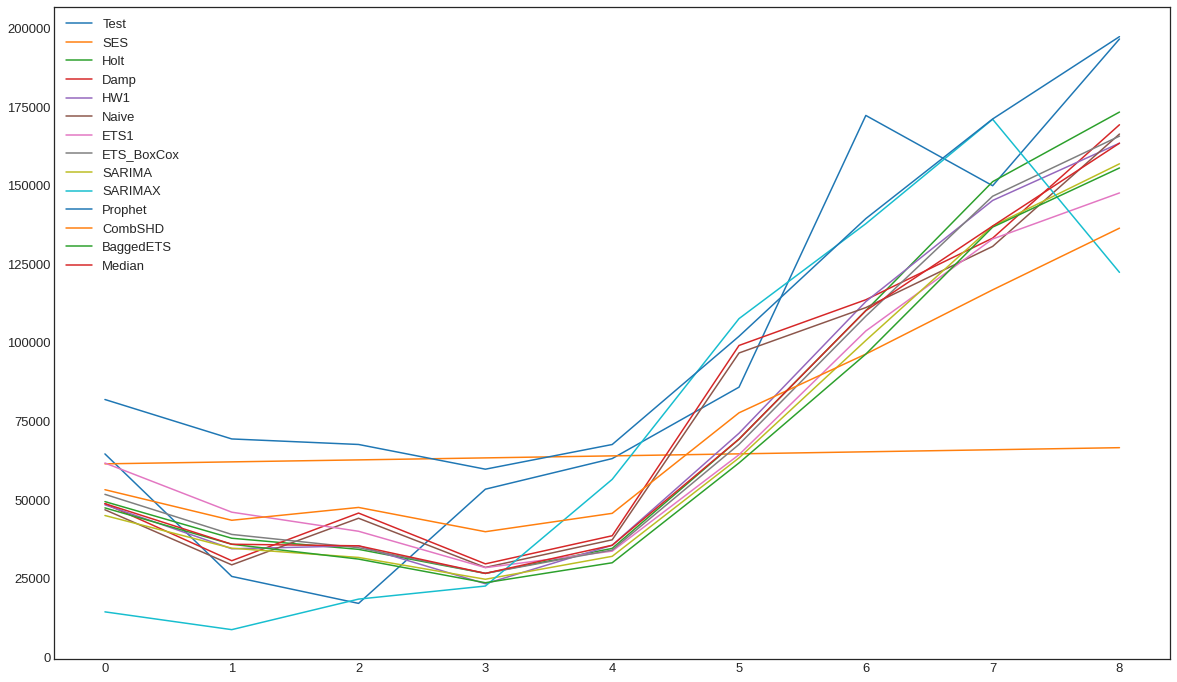

In [ ]:
firewood_results.plot(figsize=(20,12));

In [ ]:
for column in firewood_results.columns[1:]:
    print(column,":", rmse(firewood_results.Test, firewood_results[column]).round(1) )

SES : 66176.8
Holt : 27654.8
Damp : 27706.6
HW1 : 28260.9
Naive : 28861.2
ETS1 : 33828.6
ETS_BoxCox : 29062.9
SARIMA : 33076.3
SARIMAX : 35645.9
Prophet : 27130.0
CombSHD : 37155.4
BaggedETS : 34630.6
Median : 28995.0


In [ ]:
combinations(firewood_results).sort_values('RMSE').head(10)

,Models,RMSE
37,"['HW1', 'Prophet']",22614.1
24,"['Holt', 'Prophet']",22821.9
31,"['Damp', 'Prophet']",23176.8
42,"['Naive', 'Prophet']",23285.6
49,"['ETS_BoxCox', 'Prophet']",23307.0
51,"['SARIMA', 'Prophet']",24025.8
53,"['Prophet', 'BaggedETS']",24750.4
46,"['ETS1', 'Prophet']",25476.4
262,"['Holt', 'Damp', 'HW1', 'Prophet']",26539.8
101,"['Holt', 'HW1', 'Prophet']",26789.3


### Firewood

1. Best individual model is Prophet
2. Best combined model is HW1 + Prophet. %RMSE improvement ~15%

##### Final Firewood Model

In [ ]:
def firewood_forecast(series_with_dates, forecast_horizon):
    
    series_with_dates.index.freq='MS'
    #forecast_dates = series_with_dates.index.max() + 1
    train = series_with_dates.values
    train_x,lam = boxcox (train) 
    
    hw1 = (ExponentialSmoothing(train,
                           trend='add',
                           seasonal='mul',
                           seasonal_periods=12, damped=True)).fit(use_boxcox=False)

    hw1_fc = hw1.forecast(forecast_horizon)
    
    #df['HW1']= hw1_fc
    
   
    
    train_prophet_f = pd.DataFrame({'ds':pd.date_range('1-1-2012', freq='MS',periods=len(series_with_dates)), 'y':series_with_dates.values} )
    

    prophet1=Prophet(weekly_seasonality=False,
                       yearly_seasonality=True,
                       daily_seasonality=False, 
                       n_changepoints=0, 
                       seasonality_mode="additive",
                       uncertainty_samples=0).fit(train_prophet_f) 

    fb1_df=prophet1.make_future_dataframe(forecast_horizon, freq='MS')

    prophet_fc=prophet1.predict(fb1_df)[["ds","yhat"]].tail(forecast_horizon)['yhat'].values
    
    firewood_forecast =(prophet_fc + hw1_fc )/2  #pd.DataFrame({"Sales":(hw1_fc+prophet_fc)/2},index=forecast_dates) (prophet_fc + hw1_fc )/2

    
    return firewood_forecast

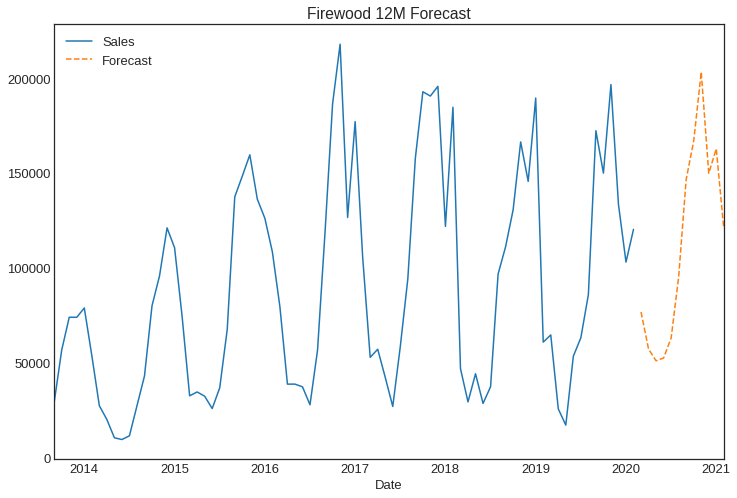

In [ ]:
fc_dates = pd.date_range(start= '2020-03-01', periods = 12, freq='MS')
firewood.plot(figsize= (12,8), title = "Firewood 12M Forecast", legend= True, label = "Sales")
pd.Series(data= firewood_forecast(firewood, 12), index = fc_dates).plot(legend= True, label = "Forecast", style = "--");

### Briquette

In [ ]:
b = clean_df[clean_df.Fuel=='Briquettes'][['Sales','Avg_Temp']].sort_index()

len_test = 3
len_val = 9
len_train = len(b) - len_test - len_val

b_train = b.iloc[:len_train]
b_val = b.iloc[len_train:(len_train+len_val)]
b_test = b.iloc[-len_test:]
b_train_b, lam_b = boxcox(b_train.Sales)


b_train.index.freq='MS'
b_val.index.freq='MS'
b_test.index.freq='MS'

In [ ]:
hw_cv(b_train.Sales,12,36,6)

add add False False     ,Expanding RMSE : 6117.1
add add False True     ,Expanding RMSE : 5206.6
add add False log     ,Expanding RMSE : 5783.9
add add True False     ,Expanding RMSE : 5747.7
add add True True     ,Expanding RMSE : 5123.4
add add True log     ,Expanding RMSE : 5238.2
add mul False False     ,Expanding RMSE : 5591.3
add mul False True     ,Expanding RMSE : 5659.4
add mul False log     ,Expanding RMSE : 5993.3
add mul True False     ,Expanding RMSE : 5866.2
add mul True True     ,Expanding RMSE : 5575.3
add mul True log     ,Expanding RMSE : 5761.4
mul add False False     ,Expanding RMSE : nan
mul add False True     ,Expanding RMSE : nan
mul add False log     ,Expanding RMSE : 6036.1
mul add True False     ,Expanding RMSE : nan
mul add True True     ,Expanding RMSE : 45510.0
mul add True log     ,Expanding RMSE : 454663.3
mul mul False False     ,Expanding RMSE : nan
mul mul False True     ,Expanding RMSE : 5708.8
mul mul False log     ,Expanding RMSE : 6191.3
mul mul Tr

In [ ]:
#SARIMA

(auto_arima(b_train_b,
           seasonal=True,
           m=12,                         
           d=1,                          
           information_criterion='aicc'). 
           summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   66
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -288.732
Date:                              Fri, 18 Sep 2020   AIC                            587.465
Time:                                      06:44:59   BIC                            598.337
Sample:                                           0   HQIC                           591.755
                                               - 66                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3124      0.099     -3.155      0.002      -0.506      -0.118
ar.L2         -0.2573      0.189     -1.359      0.174      -0.628       0.114
ar.S.L12       0.9842      0.066     14.851      0.000       0.854       1.114
ma.S.L12      -0.7904      0.415     -1.904      0.057      -1.604       0.023
sigma2       327.1103     78.696      4.157      0.000     172.868     481.352
===================================================================================
Ljung-Box (Q):                       41.85   Jarque-Bera (JB):                15.60
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               2.30   Skew:                            -0.81
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMAX(1, 1, 1)x(1, 0, 1, 12) 	

In [ ]:
briquette_results = (ts(pd.concat([b_train,b_val]).Sales, 
    fc_horizon=len(f_val), 
    seasonality=12, 
    hw_trend='add', 
    hw_seasonal='add',
    hw_damped=True,
    hw_bcox=True,
    sarima_O1=(1,1,1), 
    sarima_O2=(1,0,1,12),
    exog_series=f_train.Avg_Temp))

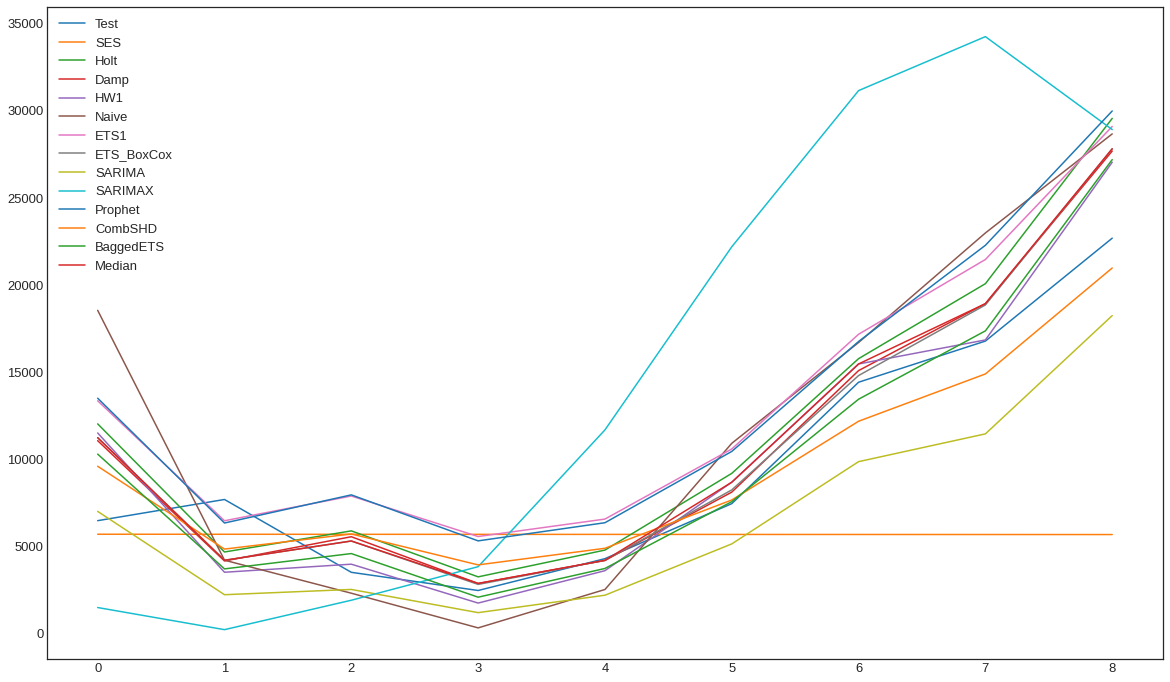

In [ ]:
briquette_results.plot(figsize=(20,12));

In [ ]:
for column in briquette_results.columns[1:]:
    print(column,":", rmse(briquette_results.Test, briquette_results[column]).round(1) )

SES : 7556.2
Holt : 3487.3
Damp : 2757.1
HW1 : 2700.2
Naive : 5360.5
ETS1 : 4259.3
ETS_BoxCox : 2781.5
SARIMA : 3517.7
SARIMAX : 10443.5
Prophet : 4488.7
CombSHD : 2021.1
BaggedETS : 2443.4
Median : 2825.1


In [ ]:
combinations(briquette_results).sort_values('RMSE').head(20)

,Models,RMSE
189,"['SES', 'Holt', 'Naive', 'SARIMA']",1661.6
239,"['SES', 'Naive', 'ETS1', 'SARIMA']",1664.9
245,"['SES', 'Naive', 'SARIMA', 'Prophet']",1669.9
210,"['SES', 'Damp', 'Naive', 'SARIMA']",1728.8
242,"['SES', 'Naive', 'ETS_BoxCox', 'SARIMA']",1757.0
220,"['SES', 'Damp', 'SARIMA', 'Prophet']",1776.8
178,"['SES', 'Holt', 'Damp', 'SARIMA']",1789.2
254,"['SES', 'ETS_BoxCox', 'SARIMA', 'Prophet']",1789.9
214,"['SES', 'Damp', 'ETS1', 'SARIMA']",1790.0
248,"['SES', 'ETS1', 'ETS_BoxCox', 'SARIMA']",1802.7


#### Observations:

   - The single best model for Briquette is combshd (2021), while the best ensemble model is ['SES', 'Holt', 'Naive', 'SARIMA'] with ~17.5% improvement in RMSE
   - It is worth noting here that all top models include some variation of SARIMA + SES + Damp, so we will use **combshd + SARIMA** (as combshd contains captures SES & Damp). combshd + SARIMA will result in ~12% improvement.
   

##### Final Briquette Model

In [ ]:
def briquette_forecast(series_with_dates, forecast_horizon):
    
    #ETS
    series_with_dates.index.freq='MS'
    
    train = series_with_dates.values
    train_x, lam  = boxcox(series_with_dates) 
    
  
    comb_fc = combshd(train, horizon = forecast_horizon, seasonality = 12, init = 'concentrated' )
    

    
    # SARIMA
    sarima =(SARIMAX(endog=train_x,                 
             order=(1,1,1),
             seasonal_order=(1,0,1,12),
             trend='c',
             enforce_invertibility=False)).fit()
    start = len(train_x)
    end = len(train_x) + forecast_horizon -1
    
    sarima_fc = inv_boxcox(sarima.predict(start, end, dynamic=False),lam)
    
    briquette_fc = pd.Series((comb_fc + sarima_fc)/2)
    
    
    
    return briquette_fc.values

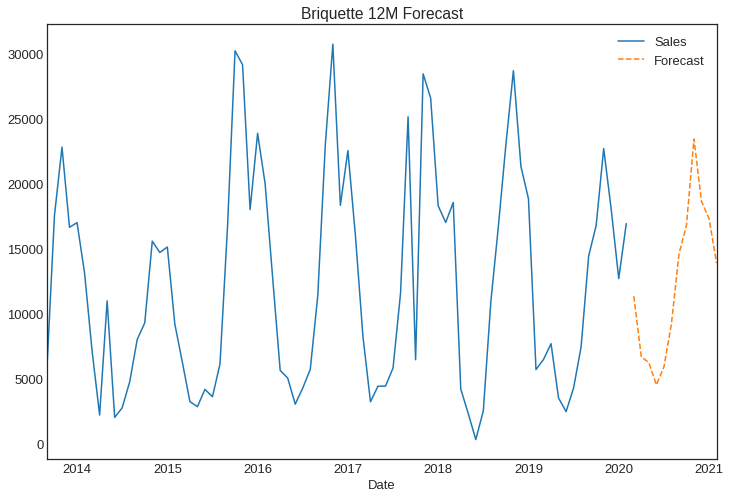

In [ ]:
fc_dates = pd.date_range(start= '2020-03-01', periods = 12, freq='MS')
briquette.plot(figsize= (12,8), title = "Briquette 12M Forecast", legend= True, label = "Sales")
pd.Series(data= briquette_forecast(briquette, 12), index = fc_dates).plot(legend= True, label = "Forecast", style = "--");

## Model Summary

Final models selected: 

1. Pellet: combshd
2. Briquette: combshd + SARIMA 
3. Firewood : HW + Prophet

It is interesting that despite avg_temperature has strong relationship with the Sales, SARIMAX model which uses temperature as an exogenous variable, did poorly compared to most methods, except for Pellet. We tried using temperature as a regressor in Prophet model too, but results did not show improvement over Prophet model. The reason could be that because weather pattern doesn't change much, monthly seasonality already captures the variation. Tempearture doesn't provide any additional information to the model that can explain sales.

We should also mention that this is a concise summary of the model fitting, evaluation process. In our exhaustive model fitting process, we also looked at the residuals to make sure residuals are not biased, are uncorrelated. 

# Data Drift

Machine Learning models and statistical models are built on the assumption that the structural pattern in the data will remain intact. When the underlying process and the distribution change, these assumptions are no longer valid and existing model can lose its predictive power. This is called as **Data Drift**. Some of the reason for data drift in sales forecasting could be: 
1. Change in Market conditions
2. Change in macro economics
3. Change in business processes
4. Change in data gathering/logging process
5. Change in customer preferences etc. 


While there are many advanced supervised and unsupervised learning methods to detect data drift, in our case since the data size is small and there is only one feature (Sales), we will define the temporal structure of the time series and use it to detect changes in the data. We are not aware of any published literature on this topic that is applicable to our case, so this is a proposed method and we plan to study is further in the future. 

We define the temporal structure by :

1. **Seasonality** : Power Spectral Density Analysis of the time series is done and peak frequency is extracted to detect seasonality
2. **Auto-correlation Function (ACF)** : Classical as well as ML methods learn from the autocorrelation structure presnet in the data. We find the dominant lags based on ACF
3. **Coefficient of Variation (CV)**: CV is calculated by dividing standard deviation of the time series by the mean. CV gives an indication of the variation in the data. If the CV varies significantly compared to historical data, it can be an indication of data drift. 



### Detect Change in Seasonality

In [ ]:
#Detecting seasonality using Power Spectral Density Analysis

def detect_seasonality(series):
    '''
    Detect seasonality based on dominant frequency using PSD analysis    
    '''   
    
    de_trended = series.diff(1).dropna()
    f, fx = signal.periodogram(de_trended)
    freq=f.reshape(len(f),1)
    psd = fx.reshape(len(f),1)
    
    df = pd.DataFrame({"Period": (1/freq).flatten(), "PSD": psd.flatten()})
    
    df = df[df["Period"]!=float('inf')].sort_values(by="PSD", ascending=False).set_index("Period")
    
    seasonality = df.idxmax().round(1).values[0]
    
    return seasonality


In [ ]:
print("Pellet Seasonality:", detect_seasonality(pellet))

print("Firewood Seasonality:", detect_seasonality(firewood))

print("Briquette Seasonality:", detect_seasonality(briquette))

Pellet Seasonality: 12.8
Firewood Seasonality: 11.0
Briquette Seasonality: 12.8


PSD analysis is influenced by the resolution of the frequency domain thus can give values very close to the actual seasonality. If the detected seasonality is outside of **+/- 1 period** of the observed seasonality, the time series can be considered to have drifted from modeling assumption.  

### Detect Change in Auto-Correlation

In [ ]:
from statsmodels.tsa.stattools import acf 

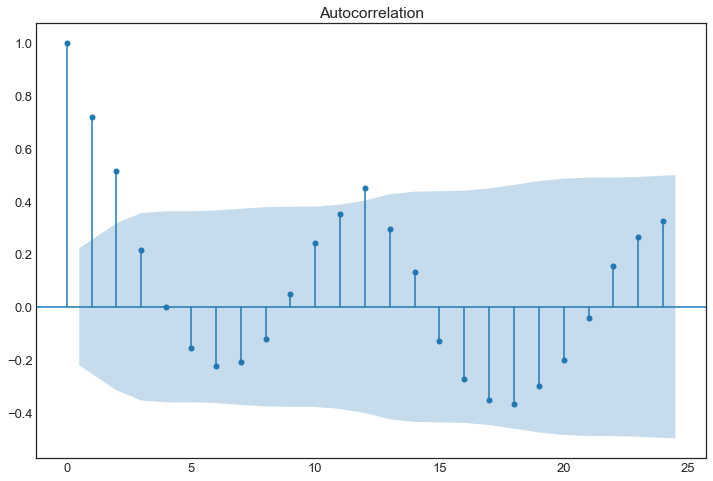

In [ ]:
plot_acf(pellet, alpha=0.05, lags=24);

As the ACF plot shows, for pellet, lags 1,2,12 are significant as they are greater than the confidence interval. In the following function, significant lags based in ACF are detected. If the new data has lags that are different from the significant lags identified previsouly, data can likely be drifiting.   

In [ ]:
def detect_acf(series, lags):
    #from statsmodels.tsa.stattools import acf 
    
    '''
    Return significant lags from the time series
    
    '''
    
    _, conf = acf(series, alpha=0.05, nlags=lags)
    
    acfs =[]
    for i in range(len(conf)):
        acfs.append(conf[i][0]*conf[i][1])
        
    lag = [] 
    for idx in range(0, len(acfs)) : 
        if acfs[idx] > 0: 
            lag.append(idx)
    return lag    
           
    
    
    

In [ ]:
print("Significant lags for Pellet are: ", detect_acf(pellet,24))
print("Significant lags for Firewood are: ", detect_acf(firewood,24))
print("Significant lags for Briquette are: ", detect_acf(briquette,24))

Significant lags for Pellet are:  [0, 1, 2, 12]
Significant lags for Firewood are:  [0, 1, 2, 5, 6, 7, 11, 12, 13]
Significant lags for Briquette are:  [0, 1, 2, 5, 6, 7, 11, 12]


### Detect Change in Variability

Coefficient of variation is defined :

cv = standard deviation / mean

CV can be used for calculating change in distribution. While there are more robust statistical methods available to compare distributions, we want to keep it simple. If the CV is within +/- 10% of the bechmark, the new data can be considered to not have drifted. 




In [ ]:
def detect_variability(series):
    return (series.values.std()/series.values.mean()).round(2)

In [ ]:
print("CV for Pellet : ", detect_variability(pellet))
print("CV for Firewood : ", detect_variability(firewood))
print("CV for Briquette : ", detect_variability(briquette))

CV for Pellet :  0.48
CV for Firewood :  0.64
CV for Briquette :  0.67


## Procedure for Detecting Data Drift

1. Run the above three functions on the data used for modeling training and forecasting
2. Run the three same functions, using same parameters, on updated time series
3. If any of the three data drift metrics are different, we recommend performing EDA again and then fitting new model based on the model training procedure laid out above.

These three metrics will be implemented directly in Power BI and calculated as new data are available. If any changes are detected, Power BI dashboard will provide a visual warning with explanation.

### Deployment

The supplier uses Power BI in his company for data analytics and distributing enterprise reports in the company. Our solution uses Power BI for ETL (Extract, Transform, Load) from the enterprise data sources in the company. Power BI dataflow is created to transform the data in a format suitable for model building. The dataflow exports the .csv file on a set schedule to Azure Data Lake Storage. Machine Learning model is built & tracked in Azure ML service in a locally deployed docker container. The scoring script runs the models, creates the forecast and saves it as a .csv file back to the Azure Data Lake. Forecast is imported in Power BI and the sales forecast is distributed to everyone in the company using Power BI. The dashboard also includes *Data Drift* metric which alerts the user if the data structure has changed.

!["Forecast Workflow"](https://raw.githubusercontent.com/pawarbi/datasets/master/forecast_workflow.jpg)